In [1]:
%load_ext autoreload
%load_ext lab_black
%autoreload 2

In [2]:
import torch

In [21]:
import os
import sys
import ast
import glob
import json
import torch
import torchmetrics
import pandas as pd
import numpy as np
from tqdm import tqdm

from omegaconf import OmegaConf
from hydra.utils import instantiate

from pytorch_lightning import Trainer
from pytorch_lightning.utilities.seed import seed_everything

sys.path.insert(0, "../")

from src.datasets import WaveformDatasetRating, WaveformDatasetRatingV2
from src.models.conformer import SelectivePartConformerGPU

from src.models.module import TrainModule, SelectiveTrainModule


os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
# all_path = glob.glob("../datasets/train_np/*/*/*.npy")
train = pd.read_csv("../datasets/2022/train_folds.csv")
train["new_target"] = (
    train["primary_label"]
    + " "
    + train["secondary_labels"].map(lambda x: " ".join(ast.literal_eval(x)))
)
train["len_new_target"] = train["new_target"].map(lambda x: len(x.split()))

In [6]:
train["file_path"] = "../datasets/2022/train_audio/" + train["filename"]

In [7]:
SelectivePartTimmSEDGPU

src.models.timmsed.SelectivePartTimmSEDGPU

In [18]:
scored_birds = "../datasets/2022/scored_birds.json"
with open(scored_birds, "r") as f:
    scored_birds_list = json.load(f)

train.loc[~train["primary_label"].isin(scored_birds_list), "kfold"] = 6
cfg = "../src/configs/conformer/conformer_exp_004.yaml"
cfg = OmegaConf.load(cfg)
cfg.model.target_columns = train.primary_label.unique().tolist()
cfg.model.num_classes = len(cfg.model.target_columns)

In [9]:
label_dict = dict()
labels = train.primary_label.unique().tolist()
for i, label in enumerate(labels):
    label_dict[label] = i

In [10]:
train["scored"] = False

In [11]:
for i, row in tqdm(train.iterrows(), total=len(train)):
    for label in row["new_target"].split():
        if label in scored_birds_list:
            train.loc[i, "scored"] = True
#         if label_dict[label] in scored_birds_list:
#             train.loc[i, "scored"] = True

100%|██████████| 14852/14852 [00:01<00:00, 13411.41it/s]


In [12]:
fold = 0
trn_df = train[train.kfold != fold].reset_index(drop=True)
val_df = train[train.kfold == fold].reset_index(drop=True)
mixup = trn_df.loc[trn_df["scored"] == True].reset_index(drop=True)

In [9]:
cfg.model.train_ds.batch_size = 48

In [19]:
train_dataset = WaveformDatasetRatingV2(trn_df, cfg.model, mode="train")
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=cfg.model.train_ds.batch_size,
    num_workers=cfg.model.valid_ds.num_workers,
    pin_memory=True,
    shuffle=True,
)

mixup_dataset = WaveformDatasetRatingV2(mixup, cfg.model, mode="train")
mixup_dataloader = torch.utils.data.DataLoader(
    mixup_dataset,
    batch_size=cfg.model.train_ds.batch_size,
    num_workers=cfg.model.valid_ds.num_workers,
    pin_memory=True,
    shuffle=True,
)


valid_dataset = WaveformDatasetRatingV2(val_df, cfg.model, mode="valid")
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=cfg.model.valid_ds.batch_size,
    num_workers=cfg.model.valid_ds.num_workers,
    pin_memory=True,
    shuffle=False,
)

In [23]:
sed_model = SelectivePartConformerGPU(cfg.model)
train_module = SelectiveTrainModule(sed_model, cfg.model, train_dataset, mixup_dataset)

In [24]:
train_inputs = next(iter(train_dataloader))
mixup_inputs = next(iter(mixup_dataloader))

In [25]:
valid_inputs = next(iter(valid_dataloader))

In [26]:
sed_model.train()

SelectivePartConformerGPU(
  (logmel_extractor): Sequential(
    (0): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
    (1): AmplitudeToDB()
  )
  (spec_augmenter): SpecAugmentation(
    (time_dropper): DropStripes()
    (freq_dropper): DropStripes()
  )
  (bn0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model): Conformer(
    (encoder): ConformerEncoder(
      (conv_subsample): Conv2dSubampling(
        (sequential): Sequential(
          (0): Conv2d(1, 512, kernel_size=(3, 3), stride=(2, 2))
          (1): ReLU()
          (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2))
          (3): ReLU()
        )
      )
      (input_projection): Sequential(
        (0): Linear(
          (linear): Linear(in_features=15872, out_features=512, bias=True)
        )
        (1): Dropout(p=0.1, inplace=False)
      )
      (layers): ModuleList(
        (0): ConformerBlock(
          (sequential): Sequential(
 

In [32]:
sed_model(
    train_inputs["image"],
    train_inputs["targets"],
    train_inputs["weight"],
    mixup_inputs["image"],
    mixup_inputs["targets"],
    mixup_inputs["weight"],
)

torch.Size([60, 313, 128])
torch.Size([60])
torch.Size([60, 77, 512])


{'framewise_output': tensor([[-1.1668,  1.5962,  0.4060,  ..., -1.2383,  1.3111,  0.4865],
         [-0.2344,  1.8706,  0.7871,  ..., -1.2848,  1.3122,  0.0823],
         [-1.4825,  2.4833, -0.3372,  ..., -0.1272,  1.6527,  0.7426],
         ...,
         [-1.6393,  0.4533,  1.1820,  ..., -0.5375,  1.6886,  0.7101],
         [-2.7409, -1.2386, -0.9894,  ...,  0.1731,  2.5388, -1.7162],
         [-3.0372, -1.3631, -1.7678,  ..., -0.1755,  2.3990, -1.1106]],
        grad_fn=<MeanBackward1>),
 'clipwise_output': tensor([[0.2374, 0.8315, 0.6001,  ..., 0.2247, 0.7877, 0.6193],
         [0.4417, 0.8665, 0.6872,  ..., 0.2167, 0.7879, 0.5206],
         [0.1850, 0.9230, 0.4165,  ..., 0.4682, 0.8393, 0.6776],
         ...,
         [0.1626, 0.6114, 0.7653,  ..., 0.3688, 0.8440, 0.6704],
         [0.0606, 0.2247, 0.2710,  ..., 0.5432, 0.9268, 0.1524],
         [0.0458, 0.2037, 0.1458,  ..., 0.4562, 0.9167, 0.2478]],
        grad_fn=<SigmoidBackward0>),
 'logit': tensor([[-1.1668,  1.5962,  0.4060

sed_model(valid_inputs["image"], valid_inputs["targets"], valid_inputs["weight"])

In [27]:
cfg.trainer.devices = 1

In [17]:
trainer = Trainer(**cfg.trainer)

MisconfigurationException: `Trainer(strategy='ddp')` or `Trainer(accelerator='ddp')` is not compatible with an interactive environment. Run your code as a script, or choose one of the compatible strategies: Trainer(strategy=None|dp|tpu_spawn). In case you are spawning processes yourself, make sure to include the Trainer creation inside the worker function.

trainer.validate(train_module, valid_dataloader)

In [15]:
cfg.model.sched.T_max = (
    len(train_dataset) // cfg.model.train_ds.batch_size * cfg.trainer.max_epochs
)

In [ ]:
trainer.fit(train_module, val_dataloaders=valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name                        | Type                | Params
--------------------------------------------------------------------
0 | model                       | SelectiveTimmSEDGPU | 6.0 M 
1 | train_f1_score_03           | F1                  | 0     
2 | train_f1_score_05           | F1                  | 0     
3 | valid_f1_score_03           | F1                  | 0     
4 | valid_f1_score_03_classwise | F1                  | 0     
5 | valid_f1_score_05           | F1                  | 0     
--------------------------------------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
24.145    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Exception ignored in: <function _releaseLock at 0x7fba92818280>
Traceback (most recent call last):
  File "/home/mega/anaconda3/envs/siim/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


In [18]:
trainer.fit?

Signature:
trainer.fit(
    model: 'pl.LightningModule',
    train_dataloaders: Union[torch.utils.data.dataloader.DataLoader, Sequence[torch.utils.data.dataloader.DataLoader], Sequence[Sequence[torch.utils.data.dataloader.DataLoader]], Sequence[Dict[str, torch.utils.data.dataloader.DataLoader]], Dict[str, torch.utils.data.dataloader.DataLoader], Dict[str, Dict[str, torch.utils.data.dataloader.DataLoader]], Dict[str, Sequence[torch.utils.data.dataloader.DataLoader]], pytorch_lightning.core.datamodule.LightningDataModule, NoneType] = None,
    val_dataloaders: Union[torch.utils.data.dataloader.DataLoader, Sequence[torch.utils.data.dataloader.DataLoader], NoneType] = None,
    datamodule: Union[pytorch_lightning.core.datamodule.LightningDataModule, NoneType] = None,
    ckpt_path: Union[str, NoneType] = None,
) -> None
Docstring:
Runs the full optimization routine.

Args:
    model: Model to fit.

    train_dataloaders: A collection of :class:`torch.utils.data.DataLoader` or a
        :cl

In [8]:
inputs = next(iter(train_dataloader))

In [ ]:
torch.Size([5, 1280, 4])

In [19]:
sed_model(inputs["image"][:5], inputs["targets"][:5], inputs["weight"][:5])

torch.Size([5, 1280, 4])


IndexError: too many indices for tensor of dimension 3

In [10]:
import matplotlib.pyplot as plt

In [53]:
mel = sed_model.logmel_extractor(inputs["image"]).unsqueeze(1).transpose(2, 3)

In [55]:
from torchlibrosa.augmentation import SpecAugmentation

spec_augmenter = SpecAugmentation(
    time_drop_width=64, time_stripes_num=2, freq_drop_width=8, freq_stripes_num=2
)

In [56]:
spec_mel = spec_augmenter(mel)

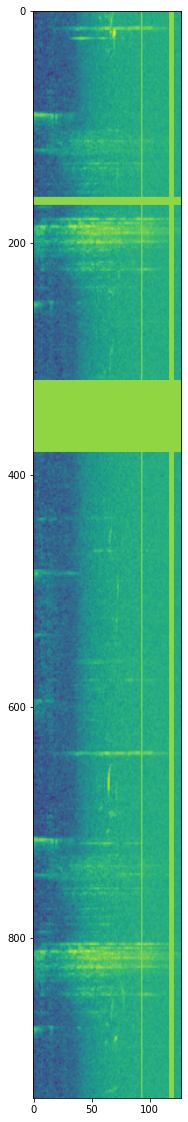

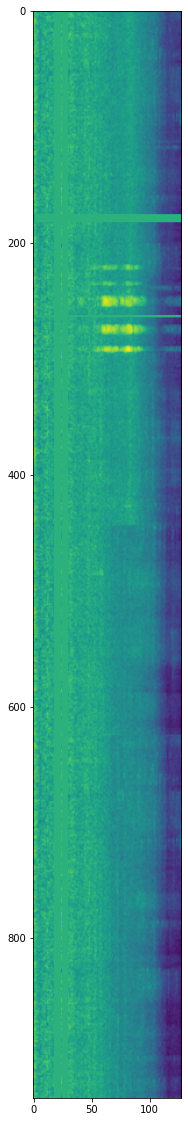

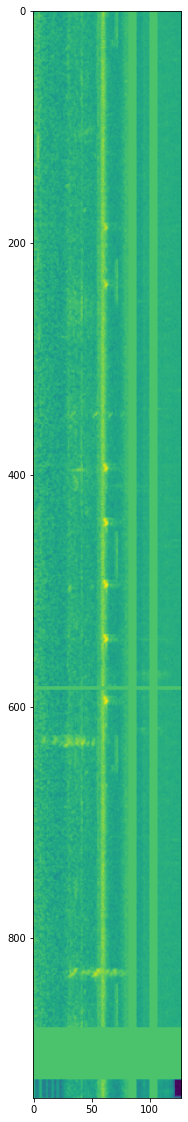

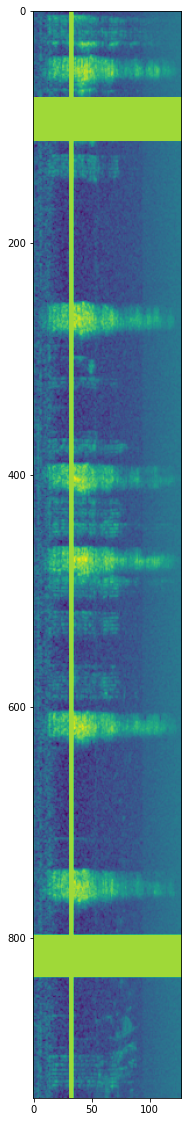

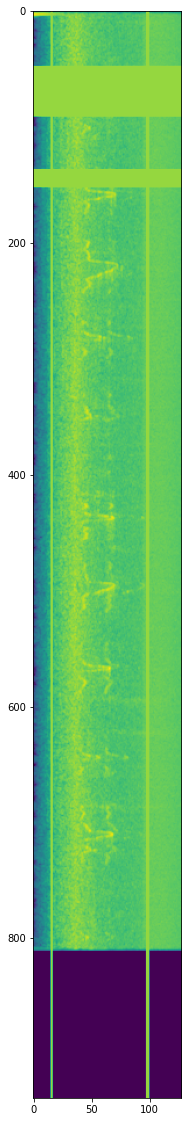

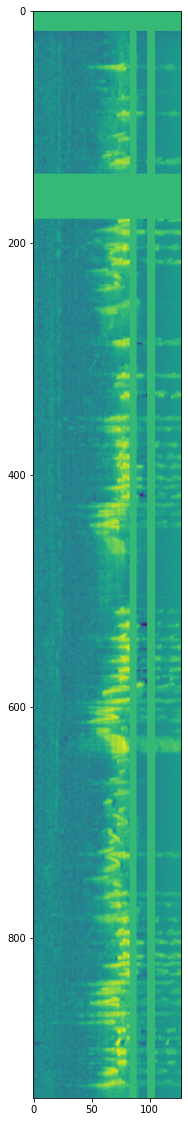

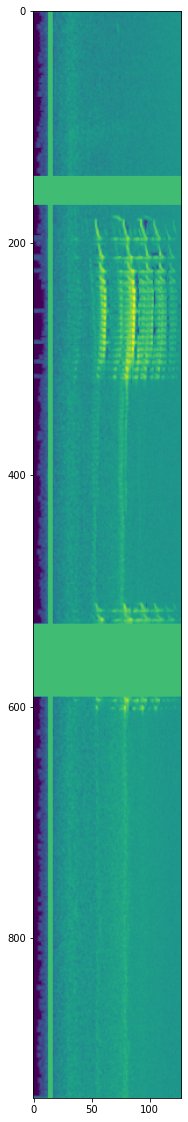

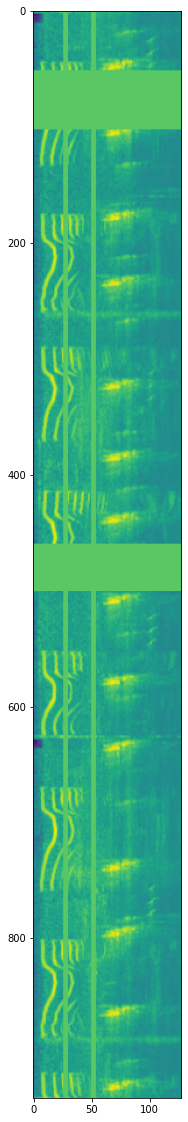

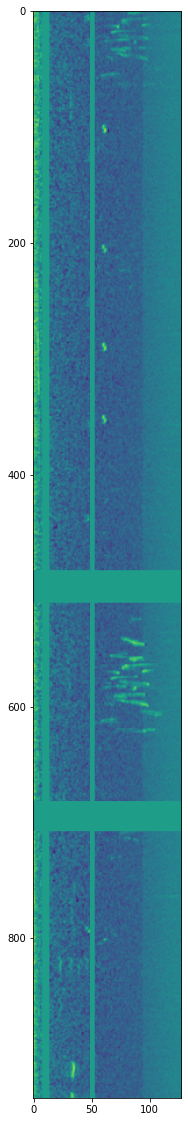

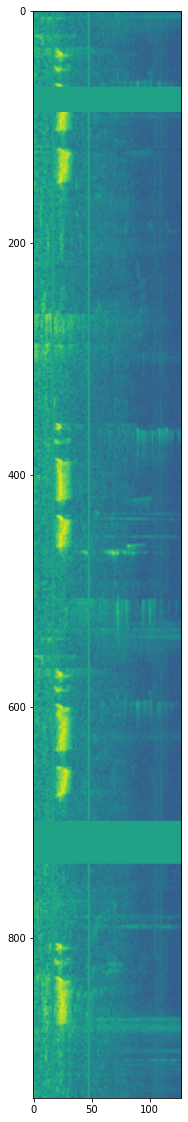

In [57]:
for i in range(10):
    plt.figure(figsize=(20, 20))
    plt.imshow(spec_mel[i].squeeze(0))

In [27]:
import torchlibrosa

In [ ]:
SpecAugmentation

In [15]:
sed_model.spec_augmenter(
    sed_model.logmel_extractor(inputs["image"]).unsqueeze(1).transpose(2, 3)
)[0]

tensor([[[-55.1921, -47.1892, -43.1473,  ..., -17.8200, -18.6205, -19.8165],
         [-54.5512, -51.0976, -49.3615,  ..., -18.2410, -18.4786, -19.3836],
         [-56.4113, -58.0230, -68.1227,  ..., -18.2461, -18.6956, -20.9126],
         ...,
         [-41.9482, -45.5310, -49.8641,  ..., -20.6413, -20.3805, -19.0203],
         [-45.6038, -49.2711, -52.3839,  ..., -18.9563, -20.4515, -20.2348],
         [-52.1042, -51.1036, -55.0109,  ..., -18.5601, -20.5905, -19.2551]]])

In [30]:
mel = sed_model.logmel_extractor(inputs["image"]).unsqueeze(1)

In [30]:
sed_model.logmel_extractor(inputs["image"][0]).shape

torch.Size([64, 1501])

In [36]:
sed_model(inputs["image"][:10], inputs["targets"][:10], inputs["weight"][:10])

torch.Size([10, 1, 1501, 64])
torch.Size([10, 1, 1501, 64])
torch.Size([10, 1280, 47, 2])


{'logit': tensor([[-2.1071, -0.7486, -1.6979,  ..., -1.9355, -0.0143, -1.7943],
         [-2.8981,  0.2803, -0.4273,  ..., -2.4457,  0.5895, -1.6338],
         [-1.1270,  0.3690, -0.9530,  ..., -1.5707,  0.4968, -1.5210],
         ...,
         [-2.2563,  0.0558, -0.2212,  ..., -1.3902, -0.0310, -1.2088],
         [-3.7043,  1.1905, -0.7308,  ..., -2.6655,  0.8311, -1.9602],
         [-2.9000, -1.2800,  0.3300,  ..., -2.4237,  0.7737, -0.7765]],
        grad_fn=<SumBackward1>),
 'framewise_logit': tensor([[[-13.3871, -10.6829,  -3.2523,  ...,  -8.5705,   0.8357,  -9.8481],
          [-13.3871, -10.6829,  -3.2523,  ...,  -8.5705,   0.8357,  -9.8481],
          [-13.3871, -10.6829,  -3.2523,  ...,  -8.5705,   0.8357,  -9.8481],
          ...,
          [ -4.6920,  -4.9826,   1.2781,  ...,  -5.2441,   1.7742,  -5.1031],
          [ -4.6920,  -4.9826,   1.2781,  ...,  -5.2441,   1.7742,  -5.1031],
          [ -4.6920,  -4.9826,   1.2781,  ...,  -5.2441,   1.7742,  -5.1031]],
 
         [[-

In [ ]:
wandb_logger = instantiate(cfg.exp_manager.logger)
wandb_logger.watch(sed_model, log="all")
lr_callback = instantiate(cfg.exp_manager.callbacks.lr_callback)
checkpoint_callback = instantiate(cfg.exp_manager.callbacks.checkpoint_callback)

# In[14]:


trainer = Trainer(**cfg.trainer, logger=wandb_logger, callbacks=[lr_callback, checkpoint_callback])


# In[ ]:


trainer.fit(train_module, train_dataloader, valid_dataloader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jjourney1125 (use `wandb login --relogin` to force relogin)


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
Using 16bit apex Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name                        | Type       | Params
-----------------------------------------------------------
0 | model                       | TimmSEDGPU | 6.0 M 
1 | train_f1_score_03           | F1         | 0     
2 | train_f1_score_05           | F1         | 0     
3 | valid_f1_score_03           | F1         | 0     
4 | valid_f1_score_03_classwise | F1         | 0     
5 | valid_f1_score_05           | F1         | 0     
-----------------------------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
24.145    Total estimated model params size (MB)


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


/home/mega/anaconda3/envs/siim/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:124: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 256.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 128.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 64.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scal